## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from decimal import Decimal

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset 

In [2]:
def load_dataset():
    train_dataset = h5py.File('../input/cat-images-dataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('../input/cat-images-dataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


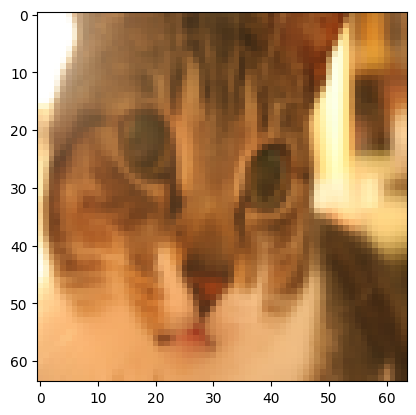

In [4]:
index = 200
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [7]:
train_set_x = np.divide(train_set_x_flatten,255)
test_set_x = np.divide(test_set_x_flatten, 255)

In [8]:
print(train_set_x)
print(test_set_x)

[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]
[[0.61960784 0.45098039 1.         ... 0.16078431 0.07058824 0.52156863]
 [0.40784314 0.43137255 0.99215686 ... 0.18431373 0.07058824 0.63921569]
 [0.3254902  0.43529412 0.99607843 ... 0.32941176 0.0627451  0.29411765]
 ...
 [0.67843137 0.67058824 0.52156863 ... 0.71764706 0.56470588 0.01960784]
 [0.50196078 0.69019608 0.39607843 ... 0.55294118 0.5372549  0.08627451]
 [0.43137255 0.72941176 0.4745098  ... 0.45490196 0.42352941 0.01960784]]


## Build neural network model

### Activation functions

In [9]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [10]:
def relu(z):
    s = np.zeros_like(z)
    s[z > 0] = z[z > 0]
    return s

In [11]:
def activation(z,function = "sigmoid"):
    if function == "tanh":
        a = np.tanh(z)
    if function == "sigmoid":
        a = sigmoid(z)
    if function == "relu":
        a = relu(z)
    return a

### Initialization

In [12]:
def layer_sizes(X, Y, n_h=5):
    n_x = X.shape[0] # size of input layer
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

In [13]:
(n_x, n_h, n_y) = layer_sizes(train_set_x, train_set_y) #,size_hiden_layer
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 12288
The size of the hidden layer is: n_h = 5
The size of the output layer is: n_y = 1


In [14]:
def random_initialize(n_x, n_h, n_y):
    np.random.seed(2)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [15]:
parameters = random_initialize(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267 -0.02136196 ... -0.01275513  0.00733372
   0.01166127]
 [ 0.00016076  0.00699494 -0.02144254 ... -0.00569705 -0.00276633
   0.0011016 ]
 [-0.00553107  0.00678748 -0.00870469 ...  0.00174631  0.00395599
  -0.00136441]
 [-0.00701089  0.00335768 -0.00122743 ...  0.01439597 -0.00733648
  -0.0040589 ]
 [-0.01336063  0.00115223 -0.00207114 ...  0.0137649  -0.02380295
  -0.01593256]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00056978 -0.0046458  -0.01014297 -0.0078986   0.00207051]]
b2 = [[0.]]


In [16]:
def initialize_with_zeros(n_x, n_h, n_y):
    W1 = np.zeros((n_h, n_x))
    b1 = np.zeros((n_h, 1))
    W2 = np.zeros((n_y, n_h))
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [17]:
parameters = initialize_with_zeros(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0. 0.]]
b2 = [[0.]]


### Parts of the model

In [18]:
def forward_propagation(X, parameters,function1 = "tanh",function2 = "sigmoid"):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = activation(Z1,function1)
    Z2 = np.dot(W2, A1) + b2
    A2 = activation(Z2,function2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [19]:
A2, cache = forward_propagation(train_set_x,parameters, function1 = "relu")
print("Z1"+ str(cache["Z1"]))
print("A1"+ str(cache["A1"]))
print("Z2"+ str(cache["Z2"]))
print("A2"+ str(cache["A2"]))

Z1[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
A1[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Z2[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
A2[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0

In [20]:
def compute_cost(A2, Y, parameters):
    
    m = Y.shape[1] # number of example

    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = - np.sum(logprobs) / m
    
    cost = Decimal(str(np.squeeze(cost)))  # makes sure cost is the dimension we expect. 
    #assert(isinstance(cost, float))
    
    return cost

In [21]:
cost = compute_cost(A2, train_set_y, parameters)
print("cost:", cost)

cost: 0.6931471805599453


In [22]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]

    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [23]:
grads = backward_propagation(parameters,cache, train_set_x,train_set_y)
print("dW1"+ str(grads["dW1"]))
print("db1"+ str(grads["db1"]))
print("dW2"+ str(grads["dW2"]))
print("db2"+ str(grads["db2"]))

dW1[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
db1[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
dW2[[0. 0. 0. 0. 0.]]
db2[[0.15550239]]


In [24]:
def update_parameters(parameters, grads, learning_rate = 0.001):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [25]:
parameters = update_parameters(parameters,grads)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0. 0.]]
b2 = [[-0.0001555]]


In [26]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype('int')
    
    return predictions

### Model function

In [27]:
def nn_model(X, Y, n_h=10, num_iterations = 5001, learning_rate = 0.01, init = "random", activate_function1 = "tanh",
             activate_function2="sigmoid", print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    costs = []

    if init == "random":
        parameters = random_initialize(n_x, n_h, n_y)
    else:
        parameters = initialize_with_zeros(n_x, n_h, n_y)
        
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters,activate_function1,activate_function2)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads,learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    predictions = predict(parameters, train_set_x)
    Y_prediction_train = float((np.dot(train_set_y,predictions.T) + np.dot(1-train_set_y,1-predictions.T))/float(train_set_y.size)*100)
    
    
    predictions = predict(parameters, test_set_x)
    Y_prediction_test = float((np.dot(test_set_y,predictions.T) + np.dot(1-test_set_y,1-predictions.T))/float(test_set_y.size)*100)
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "W1" : parameters["W1"], 
         "b1" : parameters["b1"],
         "W2" : parameters["W2"],
         "b2" : parameters["b2"],
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "init": init,
         "n_h": n_h,
         "activate_function1": activate_function1,
         "activate_function2":activate_function2
        }

    return d

### Test the model with default parametrs

In [28]:
model = nn_model(train_set_x, train_set_y, print_cost=True)
print("Y_prediction_train = " + str(model["Y_prediction_train"]))
print("Y_prediction_test = " + str(model["Y_prediction_test"]))
print("W1 = " + str(model["W1"]))
print("b1 = " + str(model["b1"]))
print("W2 = " + str(model["W2"]))
print("b2 = " + str(model["b2"]))

Cost after iteration 0: 0.693045
Cost after iteration 500: 0.502236
Cost after iteration 1000: 0.292774
Cost after iteration 1500: 0.150947
Cost after iteration 2000: 0.053152
Cost after iteration 2500: 0.032084
Cost after iteration 3000: 0.021660
Cost after iteration 3500: 0.015888
Cost after iteration 4000: 0.012428
Cost after iteration 4500: 0.010138
Cost after iteration 5000: 0.008521
Y_prediction_train = 100.0
Y_prediction_test = 70.0
W1 = [[ 0.00883522 -0.01308723 -0.02017444 ... -0.01763264 -0.0055918
   0.02902177]
 [-0.00177296  0.0092429  -0.01988866 ... -0.00411935  0.00170492
  -0.00034422]
 [-0.00916086  0.02038065 -0.00155774 ...  0.00514497  0.01600089
  -0.01414992]
 ...
 [-0.000271    0.00145129 -0.00813037 ...  0.00109349  0.02067697
  -0.00842053]
 [-0.02345059  0.00612192  0.00698249 ...  0.00594773  0.01822483
  -0.00392465]
 [-0.01451236  0.00960518  0.00474033 ...  0.01086132  0.00768976
  -0.02160337]]
b1 = [[-0.00290204]
 [ 0.00075455]
 [-0.00070853]
 [ 0.00285

## Choosing hiperparametrs

### learning rate

In [29]:
model = nn_model(train_set_x, train_set_y,num_iterations = 5001, learning_rate = 0.01, print_cost=True)
print("Y_prediction_train = " + str(model["Y_prediction_train"]))
print("Y_prediction_test = " + str(model["Y_prediction_test"]))

Cost after iteration 0: 0.693045
Cost after iteration 500: 0.502236
Cost after iteration 1000: 0.292774
Cost after iteration 1500: 0.150947
Cost after iteration 2000: 0.053152
Cost after iteration 2500: 0.032084
Cost after iteration 3000: 0.021660
Cost after iteration 3500: 0.015888
Cost after iteration 4000: 0.012428
Cost after iteration 4500: 0.010138
Cost after iteration 5000: 0.008521
Y_prediction_train = 100.0
Y_prediction_test = 70.0


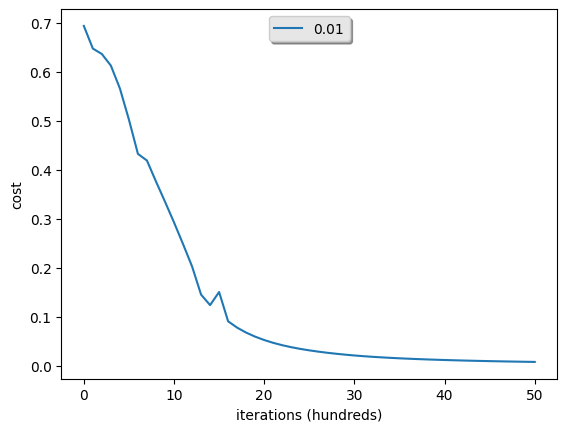

In [30]:
plt.plot(np.squeeze(model["costs"]), label= str(model["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

learning rate is: 0.1
Cost after iteration 0: 0.693045
Cost after iteration 500: 0.525101
Cost after iteration 1000: 0.500535
Cost after iteration 1500: 0.483601
Cost after iteration 2000: 0.493874
Cost after iteration 2500: 0.041037
Cost after iteration 3000: 0.028530
Cost after iteration 3500: 0.025373
Cost after iteration 4000: 0.023764
Cost after iteration 4500: 0.022988
Cost after iteration 5000: 0.022499
Cost after iteration 5500: 0.022025
Cost after iteration 6000: 0.021460
Cost after iteration 6500: 0.020888
Cost after iteration 7000: 0.019914
Cost after iteration 7500: 0.006346
Cost after iteration 8000: 0.004962
Cost after iteration 8500: 0.004223
Cost after iteration 9000: 0.003693
Cost after iteration 9500: 0.003224
Cost after iteration 10000: 0.002785
Y_prediction_train = 100.0
Y_prediction_test = 74.0

-------------------------------------------------------

learning rate is: 0.01
Cost after iteration 0: 0.693045
Cost after iteration 500: 0.502236
Cost after iteration 100

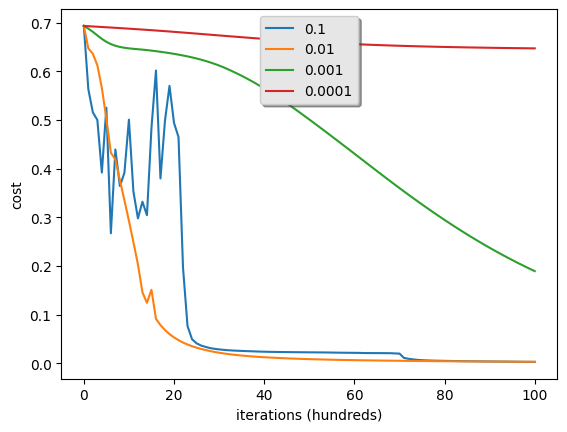

In [31]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = nn_model(train_set_x, train_set_y, n_h=10, num_iterations=10001, learning_rate = i, print_cost=True)
    print("Y_prediction_train = " + str(models[str(i)]["Y_prediction_train"]))
    print("Y_prediction_test = " + str(models[str(i)]["Y_prediction_test"]))
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Initialization type


In [32]:
model1 = nn_model(train_set_x, train_set_y, n_h=10, num_iterations=4001, learning_rate = 0.01, init = "random", print_cost=True)
print("Y_prediction_train = " + str(model1["Y_prediction_train"]))
print("Y_prediction_test = " + str(model1["Y_prediction_test"]))
print()
model2 = nn_model(train_set_x, train_set_y, n_h=10, num_iterations=4001, learning_rate = 0.01, init = "zeros", print_cost=True)
print("Y_prediction_train = " + str(model2["Y_prediction_train"]))
print("Y_prediction_test = " + str(model2["Y_prediction_test"]))


Cost after iteration 0: 0.693045
Cost after iteration 500: 0.502236
Cost after iteration 1000: 0.292774
Cost after iteration 1500: 0.150947
Cost after iteration 2000: 0.053152
Cost after iteration 2500: 0.032084
Cost after iteration 3000: 0.021660
Cost after iteration 3500: 0.015888
Cost after iteration 4000: 0.012428
Y_prediction_train = 100.0
Y_prediction_test = 70.0

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.648432
Cost after iteration 1000: 0.644415
Cost after iteration 1500: 0.644019
Cost after iteration 2000: 0.643978
Cost after iteration 2500: 0.643974
Cost after iteration 3000: 0.643974
Cost after iteration 3500: 0.643974
Cost after iteration 4000: 0.643974
Y_prediction_train = 65.55023923444976
Y_prediction_test = 34.0


In [33]:
plt.plot(np.squeeze(model1["costs"]), label= str(model1[str(i)]["init"]))
plt.plot(np.squeeze(model2["costs"]), label= str(model2[str(i)]["init"]))
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

KeyError: '0.0001'

### n_h

In [ ]:
nh_size = [10,100,1000]
models = {}
for i in nh_size:
    print ("nh_size rate is: " + str(i))
    models[str(i)] = nn_model(train_set_x, train_set_y, n_h=i, num_iterations=4001, print_cost=True)
    print ('\n' + "-------------------------------------------------------" + '\n')


In [ ]:
for i in nh_size:
    print("n_h = " + str(models[str(i)]["n_h"]))
    print("Y_prediction_train = " + str(models[str(i)]["Y_prediction_train"]))
    print("Y_prediction_test = " + str(models[str(i)]["Y_prediction_test"]))
    print()

In [ ]:
for i in nh_size:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["n_h"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Activation function

In [ ]:
model1 = nn_model(train_set_x, train_set_y, n_h=10, num_iterations=3001, learning_rate = 0.01, activate_function1="relu", print_cost=True)
print("Y_prediction_train = " + str(model1["Y_prediction_train"]))
print("Y_prediction_test = " + str(model1["Y_prediction_test"]))
print()

In [ ]:
model2 = nn_model(train_set_x, train_set_y, n_h=100, num_iterations=3001, learning_rate = 0.01, activate_function1="tanh",print_cost=True)
print("Y_prediction_train = " + str(model2["Y_prediction_train"]))
print("Y_prediction_test = " + str(model2["Y_prediction_test"]))

In [ ]:
plt.plot(np.squeeze(model1["costs"]), label= "rele")#str(model1[str(i)]["activate_function1"]))
plt.plot(np.squeeze(model2["costs"]), label= "tanh")#str(model2[str(i)]["activate_function1"]))
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Test with optimal parametrs

In [ ]:
model = nn_model(train_set_x, train_set_y, n_h=1000, num_iterations=5000, learning_rate = 0.01, activate_function1="relu", print_cost=True)
print("Y_prediction_train = " + str(model1["Y_prediction_train"]))
print("Y_prediction_test = " + str(model1["Y_prediction_test"]))